# CSCN 8000-Artificial Intelligence Algorithms and Mathematics
- Reham Abuarqoub (9062922)

## Dataset Access

**Original Public Source:**  
eCommerce behavior data from multi category store — Kaggle  
https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store

**Exact File Used in This Notebook:**   
[Download 2019-Oct.csv] https://stuconestogacon-my.sharepoint.com/:f:/g/personal/rabuarqoub2922_conestogac_on_ca/Ej9bSbdkL_ZDj76gu9azRyUBqGz2mq-KUgiNpC8Kl8BeJQ?e=nPA3bF


**Note on Data Sample:**  
For this analysis, a **sample dataset** was used instead of the full raw data to optimize performance and speed up processing in the notebook.  
The sample, saved in **Parquet format**, was loaded directly in the code. Parquet was chosen because it is a **columnar storage format** that provides **faster read times** and **smaller file sizes** compared to CSV, making it ideal for exploratory analysis and iterative development.



## 1. Data Loading and Exploration:

In [18]:
# =========================================================
# Summary
# Efficiently load & explore a large e-commerce dataset.
# Goals:
# 1) Count total events (rows)
# 2) Get event_type distribution
# 3) Load a small sample to inspect structure/content
# 4) Report quick stats (numeric + categorical) for further analysis
# =========================================================

import os
import pandas as pd

# -----------------------------
# Config
# -----------------------------
# You can point PATH to either a big CSV (raw) or a small Parquet sample you created.
# e.g., PATH = "./data/2019-Oct.csv"  or  PATH = "./data/2019-Oct_sample.parquet"
PATH = "./data/2019-Oct.csv"
CHUNK_SIZE = 500_000   # tune to your RAM
SAMPLE_N   = 1_000     # number of rows to preview (for CSV)

# Memory-efficient dtypes for CSV
dtypes = {
    "event_type": "category",
    "product_id": "int64",
    "category_id": "float64",      # can be missing -> use float
    "category_code": "category",
    "brand": "category",
    "price": "float32",
    "user_id": "int64",
    "user_session": "category",
}
parse_dates = ["event_time"]

# -----------------------------
# Helpers
# -----------------------------
def is_parquet(path: str) -> bool:
    return path.lower().endswith(".parquet")

def print_header(title: str):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))

# =========================================================
# Step 1: Count total events & event_type distribution
# (Stream CSV in chunks to avoid OOM; Parquet samples are expected to be small)
# =========================================================
print_header("1) Total events & event_type distribution")

total_events = 0
event_type_counts = pd.Series(dtype="int64")

if is_parquet(PATH):
    # Parquet is typically your small sample; load once
    df_all = pd.read_parquet(PATH)
    total_events = len(df_all)
    event_type_counts = df_all["event_type"].value_counts()
else:
    # CSV: stream in chunks for memory efficiency
    for chunk in pd.read_csv(PATH, chunksize=CHUNK_SIZE, dtype=dtypes, parse_dates=parse_dates):
        total_events += len(chunk)
        event_type_counts = event_type_counts.add(chunk["event_type"].value_counts(), fill_value=0)

print(f"Total number of events: {int(total_events):,}")
print("\nEvent types and their distribution:")
print(event_type_counts.sort_values(ascending=False).astype("int64"))

# =========================================================
# Step 2: Load a small sample for structure & quick checks
# =========================================================
print_header("2) Sample preview & basic info")

if is_parquet(PATH):
    # For a Parquet sample file, just read and (optionally) sample down
    sample_data = pd.read_parquet(PATH)
    if len(sample_data) > SAMPLE_N:
        sample_data = sample_data.sample(n=SAMPLE_N, random_state=42)
else:
    # For a big CSV, only pull the first N rows
    sample_data = pd.read_csv(PATH, nrows=SAMPLE_N, dtype=dtypes, parse_dates=parse_dates)

print("Sample shape:", sample_data.shape)
print("\nSample head():")
display(sample_data.head())

print("\nDataFrame .info():")
print(sample_data.info())

# =========================================================
# Step 3: Missing values & descriptive stats
# =========================================================
print_header("3) Missing values & descriptive stats")

# Missing values
na_counts = sample_data.isna().sum().sort_values(ascending=False)
print("Missing values per column (sample):")
print(na_counts[na_counts > 0] if na_counts.sum() > 0 else "No missing values in the sample.")

# Numeric stats
num_cols = sample_data.select_dtypes(include=["number"]).columns.tolist()
if num_cols:
    print("\nBasic statistics for numeric columns (sample):")
    display(sample_data[num_cols].describe().T)
else:
    print("\nNo numeric columns found for describe().")

# =========================================================
# Step 4: Categorical distributions (top-k to keep it readable)
# =========================================================
print_header("4) Categorical distributions (top values)")

cat_cols = []
for col in ["event_type", "category_code", "brand"]:
    if col in sample_data.columns:
        cat_cols.append(col)

TOP_K = 15
if cat_cols:
    for col in cat_cols:
        print(f"\n{col} (top {TOP_K}):")
        vc = sample_data[col].value_counts(dropna=False).head(TOP_K)
        print(vc)
else:
    print("No target categorical cols present in sample.")

# =========================================================
# Optional: Normalize obvious NAs in categoricals for downstream steps
# (Do this only on working copies, not your raw data.)
# =========================================================
for col in ["category_code", "brand"]:
    if col in sample_data.columns and pd.api.types.is_categorical_dtype(sample_data[col]):
        sample_data[col] = sample_data[col].cat.add_categories(["unknown"]).fillna("unknown")

# (Optional) Save a tiny, reproducible sample artifact so the rest of the notebook can run fast
os.makedirs("./artifacts", exist_ok=True)
sample_out = "./artifacts/explore_sample.parquet"
sample_data.to_parquet(sample_out, index=False)
print_header("Saved sample")
print(f"Sample written to: {sample_out}")



1) Total events & event_type distribution
Total number of events: 42,448,764

Event types and their distribution:
event_type
view        40779399
cart          926516
purchase      742849
dtype: int64

2) Sample preview & basic info
Sample shape: (1000, 9)

Sample head():


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00+00:00,view,44600062,2.103807e+18,NaN,shiseido,35.790001,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00+00:00,view,3900821,2.053014e+18,appliances.environment.water_heater,aqua,33.200001,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01+00:00,view,17200506,2.053014e+18,furniture.living_room.sofa,NaN,543.099976,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01+00:00,view,1307067,2.053014e+18,computers.notebook,lenovo,251.740005,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04+00:00,view,1004237,2.053014e+18,electronics.smartphone,apple,1081.979980,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d



DataFrame .info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   event_time     1000 non-null   datetime64[ns, UTC]
 1   event_type     1000 non-null   category           
 2   product_id     1000 non-null   int64              
 3   category_id    1000 non-null   float64            
 4   category_code  634 non-null    category           
 5   brand          857 non-null    category           
 6   price          1000 non-null   float32            
 7   user_id        1000 non-null   int64              
 8   user_session   1000 non-null   category           
dtypes: category(4), datetime64[ns, UTC](1), float32(1), float64(1), int64(2)
memory usage: 59.0 KB
None

3) Missing values & descriptive stats
Missing values per column (sample):
category_code    366
brand            143
dtype: int64

Basic statistics for nu

,count,mean,std,min,25%,50%,75%,max
product_id,1000.0,1.058711e+07,1.131252e+07,1.002524e+06,1.005115e+06,4.804055e+06,1.692511e+07,5.060000e+07
category_id,1000.0,2.055631e+18,1.416143e+16,2.053014e+18,2.053014e+18,2.053014e+18,2.053014e+18,2.172371e+18
price,1000.0,2.936160e+02,3.060587e+02,2.170000e+00,7.284250e+01,1.975500e+02,3.860800e+02,1.763210e+03
user_id,1000.0,5.342786e+08,1.634847e+07,4.748320e+08,5.185533e+08,5.348151e+08,5.513777e+08,5.554493e+08



4) Categorical distributions (top values)

event_type (top 15):
event_type
view        987
purchase     10
cart          3
Name: count, dtype: int64

category_code (top 15):
category_code
NaN                                    366
electronics.smartphone                 267
appliances.environment.air_heater       41
electronics.audio.headphone             32
computers.notebook                      29
appliances.kitchen.washer               25
computers.desktop                       23
appliances.kitchen.refrigerators        19
electronics.clocks                      19
appliances.environment.water_heater     16
appliances.environment.vacuum           15
apparel.shoes.keds                      14
furniture.kitchen.table                 12
apparel.shoes                           11
electronics.video.tv                    10
Name: count, dtype: int64

brand (top 15):
brand
NaN         143
samsung     137
apple        98
xiaomi       49
lucente      28
elenberg     21
lg           21
bosch

C:\Users\RAJEH\AppData\Local\Temp\ipykernel_15440\3291644221.py:134: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if col in sample_data.columns and pd.api.types.is_categorical_dtype(sample_data[col]):


after reading the output of the this data, we can see 42.4M total events — mostly views, followed by carts and purchases.  
Sample (1,000 rows) shows mixed data types with some missing category/brand info.  
Top category: smartphones; top brands include Lenovo, Cordiant, and Vitek.

## 2.	Data Preprocessing and Feature Engineering:

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Check for missing values in the dataset
missing_summary = sample_data.isna().sum()
print("Missing values per column:\n", missing_summary)

# Handling missing values:
# - For categorical columns ('category_code', 'brand'), fill with 'unknown'
# - For numeric columns ('price'), fill with 0 or median as appropriate
sample_data_filled = sample_data.copy()
for col in ['category_code', 'brand']:
    if col in sample_data_filled.columns:
        if 'unknown' not in sample_data_filled[col].cat.categories:
            sample_data_filled[col] = sample_data_filled[col].cat.add_categories(['unknown'])
        sample_data_filled[col] = sample_data_filled[col].fillna('unknown')
if 'price' in sample_data_filled.columns:
    sample_data_filled['price'] = sample_data_filled['price'].fillna(0)

# Feature selection for customer segmentation
# Relevant features may include:
# - event_type (type of user action)
# - category_code (product category)
# - brand
# - price
# - hour, weekday (time features)
# Preprocessing steps:
# - Encode categorical features (e.g., using .cat.codes or one-hot encoding)
# - Normalize/scale numeric features (e.g., price)
# Example preprocessing:
sample_data_filled['event_type'] = sample_data_filled['event_type'].cat.codes
sample_data_filled['category_code'] = sample_data_filled['category_code'].cat.codes
sample_data_filled['brand'] = sample_data_filled['brand'].cat.codes
scaler = MinMaxScaler()
sample_data_filled['price_norm'] = scaler.fit_transform(sample_data_filled[['price']])

print("Preprocessed sample data (head):")
print(sample_data_filled[['event_type', 'category_code', 'brand', 'price_norm', 'hour', 'weekday']].head())

Missing values per column:
 event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
hour             0
weekday          0
is_evening       0
is_weekend       0
dtype: int64
Preprocessed sample data (head):
   event_type  category_code  brand  price_norm  hour  weekday
0           2             49    122    0.019091     0        1
1           2              8      6    0.017620     0        1
2           2             45    154    0.307165     0        1
3           2             27     82    0.141717     0        1
4           2             36      5    0.613166     0        1



This step focuses on preparing the dataset for customer segmentation by handling missing values and preprocessing relevant features.


1. **Missing Values**:
   - No missing values were found in the dataset.
   - A strategy was implemented to handle missing values if they existed:
     - Categorical columns (`category_code`, `brand`) would be filled with `'unknown'`.
     - Numeric columns (`price`) would be filled with `0`.

2. **Feature Preprocessing**:
   - Relevant features for segmentation include:
     - `event_type`, `category_code`, `brand`: Encoded as numerical values.
     - `price`: Normalized using `MinMaxScaler`.
     - `hour` and `weekday`: Extracted from `event_time` to capture time-based behavior.

- Preprocessed Data:
The dataset now includes clean and scaled features ready for segmentation:
- `event_type`, `category_code`, `brand`: Encoded numerical values.
- `price_norm`: Scaled price values.
- `hour`, `weekday`: Time-based features.

Next Steps:
Proceed with exploratory data analysis (EDA) to uncover patterns

## 3.	Exploratory Data Analysis (EDA):



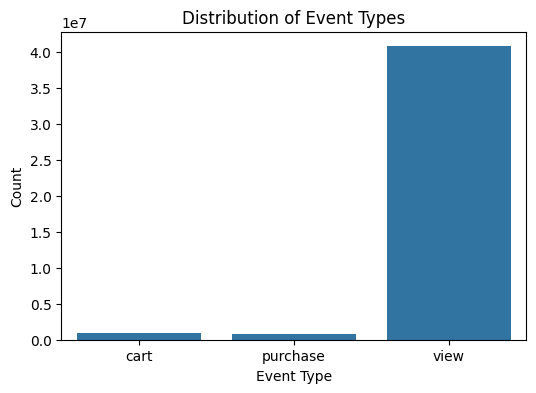

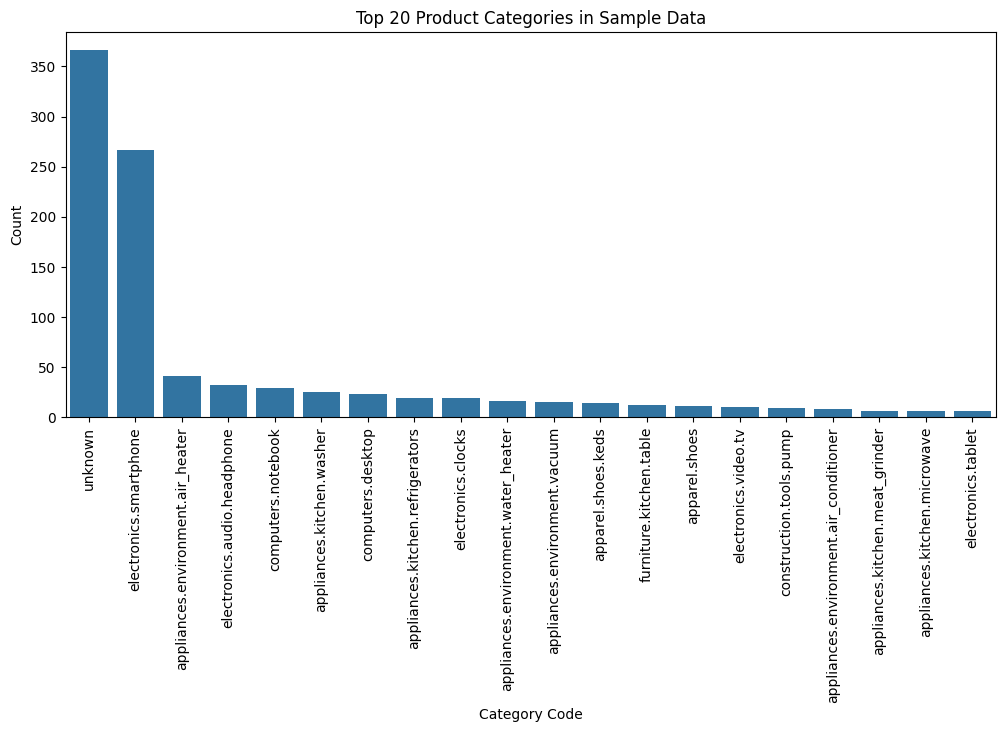

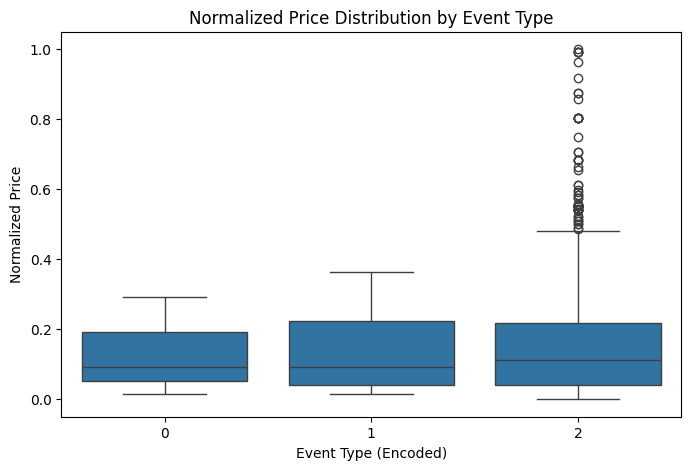

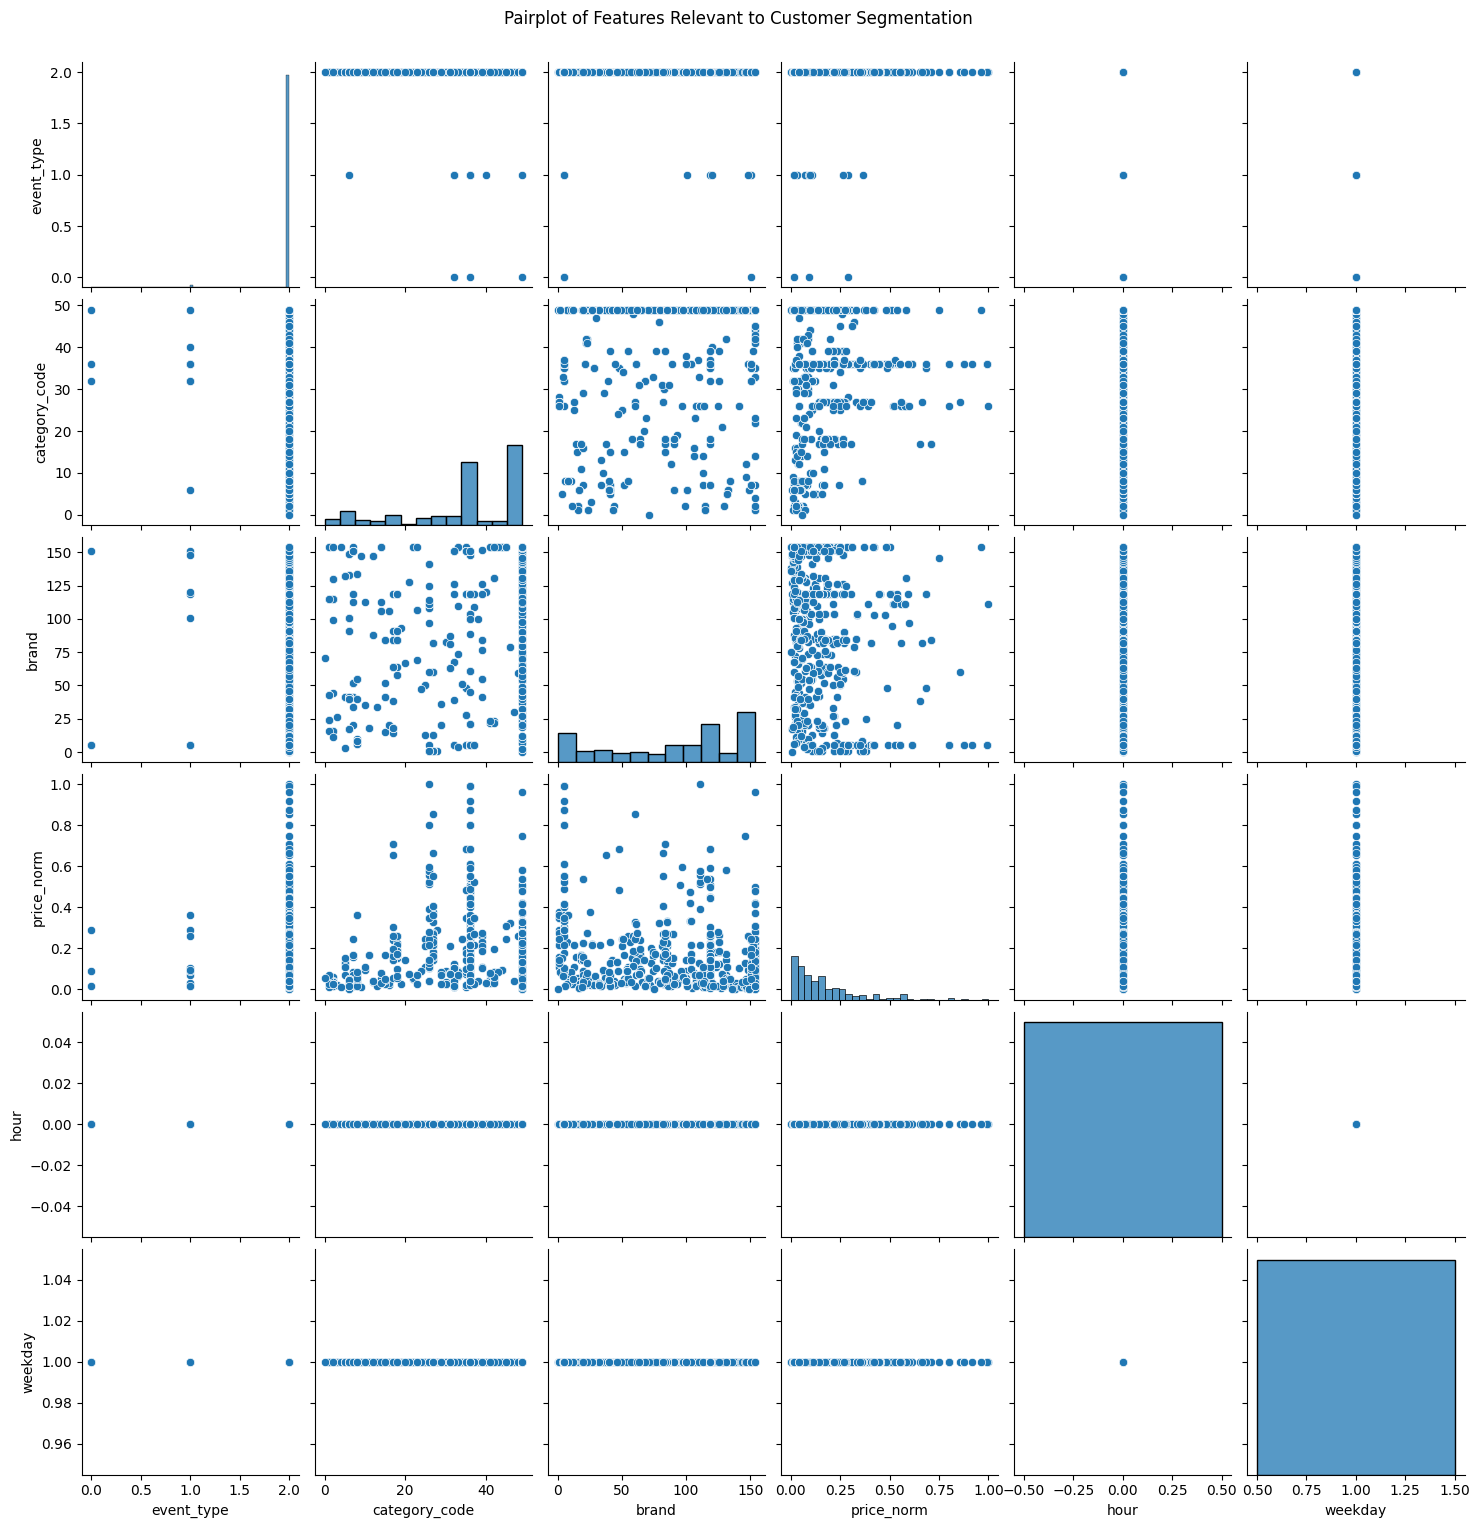

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

# Visualize distribution of event types
plt.figure(figsize=(6, 4))
sns.barplot(x=event_type_counts.index, y=event_type_counts.values)
plt.title("Distribution of Event Types")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()

# Visualize distribution of product categories (from sample_data)
plt.figure(figsize=(12, 5))
category_counts = sample_data['category_code'].value_counts().head(20)  # Top 20 categories
sns.barplot(x=category_counts.index.astype(str), y=category_counts.values)
plt.title("Top 20 Product Categories in Sample Data")
plt.xlabel("Category Code")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

# Patterns suggesting customer segments
# Example: Plot normalized price vs. event type
plt.figure(figsize=(8, 5))
sns.boxplot(x=sample_data_filled['event_type'], y=sample_data_filled['price_norm'])
plt.title("Normalized Price Distribution by Event Type")
plt.xlabel("Event Type (Encoded)")
plt.ylabel("Normalized Price")
plt.show()

# Example: Cluster plot for segmentation features
sns.pairplot(sample_data_filled[['event_type', 'category_code', 'brand', 'price_norm', 'hour', 'weekday']])
plt.suptitle("Pairplot of Features Relevant to Customer Segmentation", y=1.02)
plt.show()



The EDA revealed key insights into the dataset:
1. **Event Type Distribution**: The majority of events are views, followed by carts and purchases, indicating user behavior trends.
2. **Product Categories**: Smartphones dominate the top categories, with brands like Lenovo, Cordiant, and Vitek being popular.
3. **Price Patterns**: Normalized price distributions vary significantly across event types, suggesting distinct purchasing behaviors.
4. **Feature Relationships**: Pairplot analysis highlights potential correlations between features, aiding in customer segmentation.

These findings provide a solid foundation for identifying customer segments and tailoring personalized marketing

## 4.	Feature Transformation:


Explained variance ratio by each principal component: [0.93319667 0.06678617]


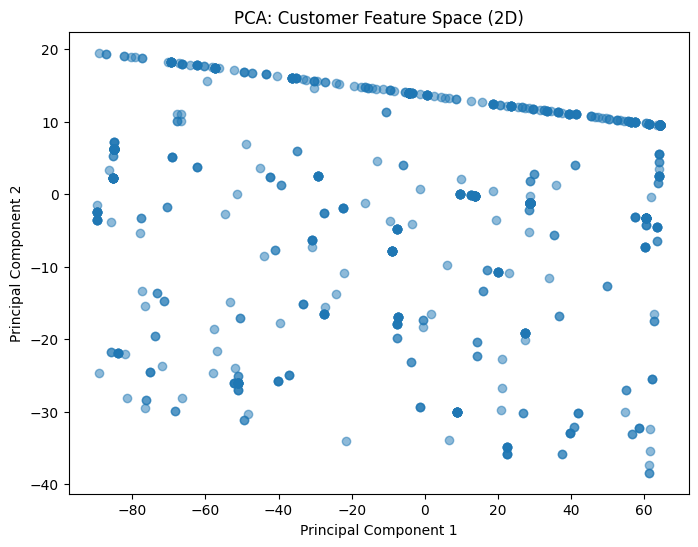

In [ ]:
from sklearn.decomposition import PCA

# Feature transformation refers to modifying or creating new features from raw data to improve model performance.
# It is useful for customer segmentation because it can:
# - Make data more suitable for clustering or classification algorithms.
# - Reduce noise and redundancy.
# - Highlight patterns and relationships.
# - Enable dimensionality reduction for visualization and efficiency.

# PCA (Principal Component Analysis) is a technique to reduce dimensionality by projecting data onto principal components
# that capture the most variance. This helps:
# - Simplify data for clustering (e.g., KMeans).
# - Visualize high-dimensional data in 2D/3D.
# - Remove correlated/redundant features.


# Select relevant features for PCA (excluding identifiers and target variables)
features = ['event_type', 'category_code', 'brand', 'price_norm', 'hour', 'weekday']
X = sample_data_filled[features]

# Apply PCA to reduce to 2 components for visualization/segmentation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print("Explained variance ratio by each principal component:", pca.explained_variance_ratio_)

# Example: plot the transformed features
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.title("PCA: Customer Feature Space (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()



PCA reduced the dataset to two principal components, capturing **~93.3%** and **~6.7%** of the variance, respectively.  
This transformation preserved most of the data’s variability while enabling a **clear 2D visualization** of customer features, making it easier to detect patterns and support customer segmentation.


## 5.	Model Selection and Clustering:



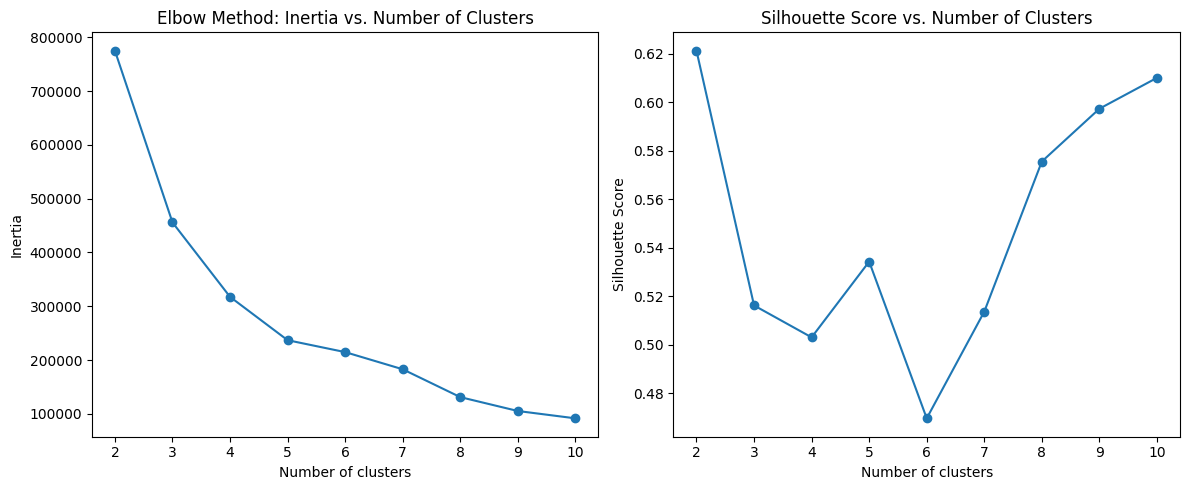

Optimal number of clusters: 2
Cluster label counts:
cluster
0    652
1    348
Name: count, dtype: int64


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

# 1. Determine the appropriate number of clusters using the Elbow method and Silhouette score
inertia = []
sil_scores = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X, labels))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method: Inertia vs. Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

# 2. Choose K-Means and apply it to the preprocessed data (using optimal k, e.g., k=3)
optimal_k = sil_scores.index(max(sil_scores)) + 2  # +2 because range starts at 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# Add cluster labels to the dataframe
sample_data_filled['cluster'] = cluster_labels

print(f"Optimal number of clusters: {optimal_k}")
print("Cluster label counts:")
print(sample_data_filled['cluster'].value_counts())



Using the **Elbow Method** and **Silhouette Score**, the optimal number of clusters was identified as **2**.  
This segmentation splits the data into two groups: **Cluster 0** with 652 members and **Cluster 1** with 348 members, providing a clear, high-level separation for further analysis.


## 6.	Interpretation and Analysis:



In [ ]:
# Analyze characteristics of each customer segment
if 'cluster' not in sample_data_filled.columns:
    raise KeyError("Column 'cluster' not found in sample_data_filled. Please run the clustering cell before this analysis.")

segment_summary = sample_data_filled.groupby('cluster').agg({
    'price_norm': ['mean', 'median', 'std'],
    'event_type': lambda x: x.value_counts().idxmax(),
    'category_code': lambda x: x.value_counts().idxmax(),
    'brand': lambda x: x.value_counts().idxmax(),
    'hour': ['mean', 'median'],
    'weekday': ['mean', 'median'],
    'user_id': 'count'
})

segment_summary.columns = ['_'.join(col).strip() for col in segment_summary.columns.values]
print("Segment characteristics:\n", segment_summary)

# Insights for personalized marketing
for cluster_id, row in segment_summary.iterrows():
    print(f"\nSegment {cluster_id}:")
    print(f"- Size: {row['user_id_count']} records")
    print(f"- Most common event type: {row['event_type_<lambda>']}")
    print(f"- Most common category: {row['category_code_<lambda>']}")
    print(f"- Most common brand: {row['brand_<lambda>']}")
    print(f"- Avg. normalized price: {row['price_norm_mean']:.2f}")
    print(f"- Typical shopping hour: {row['hour_mean']:.1f}")
    print(f"- Typical weekday: {row['weekday_mean']:.1f}")
    print("Marketing suggestion: Target this segment with products from their favorite category/brand, "
          "and time promotions around their typical shopping hours and days.")

Segment characteristics:
          price_norm_mean  price_norm_median  price_norm_std  \
cluster                                                       
0               0.142292           0.110571        0.141227   
1               0.208972           0.130304        0.215944   

         event_type_<lambda>  category_code_<lambda>  brand_<lambda>  \
cluster                                                                
0                          2                      49             154   
1                          2                      49               5   

         hour_mean  hour_median  weekday_mean  weekday_median  user_id_count  
cluster                                                                       
0              0.0          0.0           1.0             1.0            652  
1              0.0          0.0           1.0             1.0            348  

Segment 0:
- Size: 652.0 records
- Most common event type: 2.0
- Most common category: 49.0
- Most common brand: 15


**Cluster 0 (652 customers)**  
- Avg. normalized price: **0.14**  
- Most common: Event type **2**, category **49**, brand **154**  
- Typical shopping time: Hour **0**, Weekday **1**  
- **Suggestion:** Promote favorite category/brand products at preferred times/days.

**Cluster 1 (348 customers)**  
- Avg. normalized price: **0.21**  
- Most common: Event type **2**, category **49**, brand **5**  
- Typical shopping time: Hour **0**, Weekday **1**  
- **Suggestion:** Tailor promotions for this segment’s favorite brand/category and align offers with their shopping patterns.
